In [1]:
import numpy as np
import torch

torch.manual_seed(0)

import gpytorch
import botorch

from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from botorch.models.model_list_gp_regression import ModelListGP

from botorch.acquisition.analytic import ExpectedImprovement
from botorch.acquisition.multi_objective.analytic import ExpectedHypervolumeImprovement

from botorch.optim.optimize import optimize_acqf

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

from tqdm.notebook import tqdm
import warnings

In [2]:
def objective1(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1 + x / 20
    return y


def objective2(x):
    return (0.1 * objective1(x) + objective1(x - 4)) / 3 - x / 3 + 0.5


def joint_objective(x):
    y1 = objective1(x)
    y2 = objective2(x)
    
    return torch.vstack([y1.flatten(), y2.flatten()]).transpose(-1, -2)


lb = -5
ub = 5

bounds = torch.tensor([[lb], [ub]], dtype=torch.float)

xs = torch.linspace(lb, ub, 201)
ys = joint_objective(xs)
ref_point = torch.tensor([ys[:, 0].min(), ys[:, 1].min()])

In [3]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=1)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in range(num_train_iters):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

In [4]:
num_queries = 20
num_repeats = 10

In [5]:
strategy = "alt_ei"  # "alt_ei" or "ehvi"
strategy = strategy.upper()

hypervolumes = torch.zeros((num_repeats, num_queries))

for trial in range(num_repeats):
    print("trial", trial)
    
    torch.manual_seed(trial)
    train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(1, 1)
    train_y = joint_objective(train_x)
    
    for i in tqdm(range(num_queries)):
        dominated_part = DominatedPartitioning(ref_point, train_y)
        hypervolumes[trial, i] = dominated_part.compute_hypervolume().item()
        
        model1, likelihood1 = fit_gp_model(train_x, train_y[:, 0])
        model2, likelihood2 = fit_gp_model(train_x, train_y[:, 1])
        
        if strategy == "ALT_EI":
            if i % 2 == 0:
                model = model1
                best_f = train_y[:, 0].max()
            else:
                model = model2
                best_f = train_y[:, 1].max()
            
            policy = ExpectedImprovement(model=model, best_f=best_f)
        
        if strategy == "EHVI":
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                
                policy = ExpectedHypervolumeImprovement(
                    model=ModelListGP(model1, model2),
                    ref_point=ref_point,
                    partitioning=FastNondominatedPartitioning(ref_point, train_y)
                )
        
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=RuntimeWarning)
            next_x, acq_val = optimize_acqf(
                policy,
                bounds=bounds,
                q=1,
                num_restarts=20,
                raw_samples=50
            )
        
        next_y = joint_objective(next_x)
        
        train_x = torch.cat([train_x, next_x])
        train_y = torch.cat([train_y, next_y])

trial 0


  0%|          | 0/20 [00:00<?, ?it/s]

trial 1


  0%|          | 0/20 [00:00<?, ?it/s]

trial 2


  0%|          | 0/20 [00:00<?, ?it/s]

trial 3


  0%|          | 0/20 [00:00<?, ?it/s]

trial 4


  0%|          | 0/20 [00:00<?, ?it/s]

trial 5


  0%|          | 0/20 [00:00<?, ?it/s]

trial 6


  0%|          | 0/20 [00:00<?, ?it/s]

trial 7


  0%|          | 0/20 [00:00<?, ?it/s]

trial 8


  0%|          | 0/20 [00:00<?, ?it/s]

trial 9


  0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
torch.save(hypervolumes, f"./forrester/{strategy}.pth")

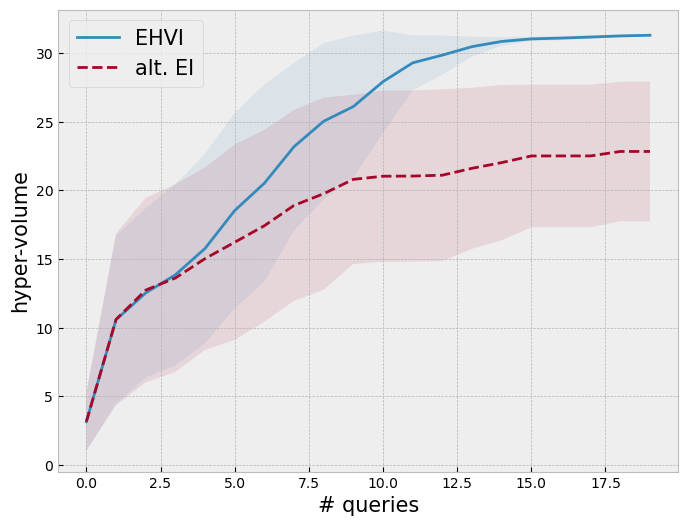

In [7]:
def show_agg_progress(path, name, linestyle="solid"):
    def ci(y):
        return 2 * y.std(axis=0) / np.sqrt(num_repeats)

    incumbents = torch.load(path)
    avg_incumbent = incumbents.mean(axis=0)
    ci_incumbent = ci(incumbents)

    plt.plot(avg_incumbent, linestyle=linestyle, label=name)
    plt.fill_between(
        np.arange(num_queries),
        avg_incumbent + ci_incumbent,
        avg_incumbent - ci_incumbent,
        alpha=0.1,
    )


show_agg_progress("./forrester/EHVI.pth", "EHVI",)
show_agg_progress("./forrester/ALT_EI.pth", "alt. EI", linestyle="--")

plt.xlabel("# queries", fontsize=15)
plt.ylabel("hyper-volume", fontsize=15)

plt.legend(fontsize=15);

In [9]:
torch.save(train_x, "./forrester/train_x.pth")
torch.save(train_y, "./forrester/train_y.pth")